# Dataset

## Importing

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
from scipy.io import loadmat
Data_set = loadmat('/content/drive/MyDrive/All_data.mat')
print(type(Data_set))
print(Data_set.keys())
x_train = Data_set['x_train']
y_train = Data_set['y_train']
x_test = Data_set['x_test']
print(type(x_train))
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)

<class 'dict'>
dict_keys(['__header__', '__version__', '__globals__', 'clab', 'x_test', 'x_train', 'y_train'])
<class 'numpy.ndarray'>
(50, 28, 316)
(1, 316)
(50, 28, 100)


## Feature Exateraction Time Domain

## Variance

In [3]:
Total_Features = np.zeros((2000,416), dtype=float)
Total_data = np.zeros((50, 28, 416), dtype=float)
Total_data[:, :, 0:316] = x_train
Total_data[:, :, 316:416] = x_test
Total_Features[0:28,:] = np.var(Total_data, axis=0)

## histogram

In [4]:
min_domain=Total_data.min()
max_domain=Total_data.max()

print(min_domain)
print(max_domain)
for i in range(416):
  for j in range(28):
    Total_Features[28+10*(j):38+(j)*10,i], _ = np.histogram(Total_data[:,j,i], bins=10, range=(Total_data[:,j,:].min(), Total_data[:,j,:].max()) )

print(Total_Features[38:48:,285])


-178.60000000000002
220.3
[ 0.  0.  0.  0.  0. 18. 23.  6.  3.  0.]


## Form Factor

In [5]:
Total_Features[308:336,:] = (np.std(np.diff(Total_data, n=2, axis=0), axis=0))*(np.std(Total_data, axis=0))/(np.std(np.diff(Total_data, n=1, axis=0), axis=0)**2)

# print(Total_Features[308+10,0])


## Corrolation

In [6]:
cnt=0
for i in range(416):
  for j in range(28):
    for k in range(j+1,28):
      Total_Features[336+cnt,i] = np.sum((Total_data[:,j,i]-np.mean(Total_data[:,j,i]))*(Total_data[:,k,i]-np.mean(Total_data[:,k,i])))/50
      cnt = cnt +1
  cnt=0

# print(Total_Features[336:714,200])

## skewness & kurtosis

In [7]:
from scipy.stats import kurtosis, skew
Total_Features[714: 742, :] = kurtosis(Total_data, axis=0)
Total_Features[742: 770, :] = skew(Total_data, axis=0)

## Feature Exateraction Freq Domain

## bandpower

In [8]:
import scipy 

# def bandpower(x, fs, fmin, fmax):
#     # f, Pxx = scipy.signal.periodogram(x, fs=fs)
#     f, Pxx = scipy.signal.welch(x, fs)
#     ind_min = np.argmax(f > fmin) - 1
#     ind_max = np.argmax(f > fmax) - 1
#     return np.trapz(Pxx[ind_min: ind_max], f[ind_min: ind_max])

def bandpower(x, fs, fmin, fmax):
    f, Pxx = scipy.signal.periodogram(x, fs=fs)
    ind_min = scipy.argmax(f > fmin) - 1
    ind_max = scipy.argmax(f > fmax) - 1
    return scipy.trapz(Pxx[ind_min: ind_max], f[ind_min: ind_max])


In [9]:
Freq_bandwidth=np.array([[2, 8], [9, 15], [16, 22], [23, 29], [30, 36], [37, 43], [44, 50]])
Fs=100

for i in range(416):
  for j in range(28):
    for k in range(7):
      Total_Features[770+7*j+k,i] = bandpower(Total_data[:,j,i], Fs, Freq_bandwidth[k,0], Freq_bandwidth[k,1])/bandpower(Total_data[:,j,i], Fs, 2, 50)

# print(Total_Features[1120:1127, 1])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: scipy.argmax is deprecated and will be removed in SciPy 2.0.0, use numpy.argmax instead
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: scipy.argmax is deprecated and will be removed in SciPy 2.0.0, use numpy.argmax instead
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: scipy.trapz is deprecated and will be removed in SciPy 2.0.0, use numpy.trapz instead
  


## maxfreq

In [10]:
# print(Total_Features[1315,1])
n=50
Freq_Doamin = abs(np.fft.fft(Total_data, n=50, axis= 0))
print(np.argmax(Freq_Doamin[0:24,:,:], axis=0).shape)
Total_Features[966:994,:] = 2*np.argmax(Freq_Doamin[0:24,:,:], axis=0)
# print(Total_Features[1316:1344,110])

(28, 416)


## meanfreq

In [11]:
w=np.linspace(0, 24, num=25, endpoint=True).reshape(25,1)
for i in range(416):
  Total_Features[994:1022, i] = 2*(np.sum(Freq_Doamin[0:25,:,i]*w, axis=0)/(np.sum(Freq_Doamin[0:25,:,i], axis=0))).reshape(28,)
# print(Total_Features[1344:1372, 401])
# w.shape

## medianfreq

In [12]:
# Signal Power Spectrum
from scipy.integrate import cumtrapz
from scipy.signal import welch
from numpy import where

def medianfreq(signal, fs):
  f, P = welch(signal, fs=fs)

  # Total Power and Median Frequency (Frequency that divides the spectrum into two regions with equal power)
  area_freq = cumtrapz(P, f, initial=0)
  total_power = area_freq[-1]
  median_freq = f[where(area_freq >= total_power / 2)[0][0]]
  return median_freq

In [13]:
for i in range(416):
  for j in range(28):
    Total_Features[1022+j , i] = medianfreq(Total_data[:, j, i], fs=Fs)

/usr/local/lib/python3.7/dist-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 50, using nperseg = 50
  .format(nperseg, input_length))


## bandpower2

In [14]:
import math
Freq_bandwidth = np.array([[2, 8], [9, 15], [16, 22], [23, 29], [30, 36], [37, 43], [44, 50]])
Freq_Doamin = abs(np.fft.fft(Total_data, n=50, axis= 0))
Fs=100
for i in range(416):
  for j in range(28):
    for k in range(7):
      Total_Features[1050+7*j+k,i] = np.sum((Freq_Doamin[math.floor(Freq_bandwidth[k,0]/2):math.floor(Freq_bandwidth[k,1]/2), j, i])**2)/(np.sum((Freq_Doamin[0:25, j, i])**2))

# print(Total_Features[1050,1])

## MATLAB Features

In [15]:
Frequency_features = loadmat('/content/drive/MyDrive/Frequency_features.mat')
Frq_features = Frequency_features['Total_Features_frq']
Total_Features[1246:1498, :] = Frq_features

## Fisher cirteria

In [16]:
def my_fisher(Initial_feature_ind, Final_feature_ind, Total_Features, number_of_best_features):
  number_of_features = abs( Final_feature_ind - Initial_feature_ind)
  Length_class_one= np.sum(y_train, axis=1)
  Class_one_features = np.zeros((number_of_features,int(Length_class_one)))
  Class_zero_features = np.zeros((number_of_features,316-int(Length_class_one)))
  Fisher_score= np.zeros((number_of_features,1))
  j=0
  k=0
  for i in range(316):
    if y_train[0,i]==1:
      Class_one_features[:,j]=Total_Features[Initial_feature_ind:Final_feature_ind,i]
      j+=1;
    else:
      Class_zero_features[:,k]=Total_Features[Initial_feature_ind:Final_feature_ind,i]
      k+=1;
  u_total = np.mean(Total_Features[Initial_feature_ind:Final_feature_ind, 0:316], axis=1)
  variance_total = np.var(Total_Features[Initial_feature_ind:Final_feature_ind, 0:316], axis=1)
  u_class_one = np.mean(Class_one_features, axis=1)
  u_class_zero = np.mean(Class_zero_features, axis=1)
  variance_class_one = np.var(Class_one_features, axis=1)
  variance_class_zero = np.var(Class_zero_features, axis=1)
  Fisher_score = (((abs(u_total - u_class_one) ** 2) + (abs(u_total - u_class_zero) ** 2))/( variance_class_one + variance_class_zero)).reshape(number_of_features,1)
  # print(Fisher_score[710:800, 0])
  return np.argsort(-Fisher_score, axis=0)[0:number_of_best_features]

# print(Ind_features[0:30])

## 32 of best features for training

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide


Time Domain features [[691 697  26 684 325 621 702  21 692  20 698 686 634 685 616 713]] 

Frequecncy Domain features [[ 891  898  915  957 1423  940  892  947  842  908  884 1332  782 1430
   810  922]] 

Total features [[ 691  697   26  684  325  621  702   21  692   20  698  686  634  685
   616  713  891  898  915  957 1423  940  892  947  842  908  884 1332
   782 1430  810  922]] 



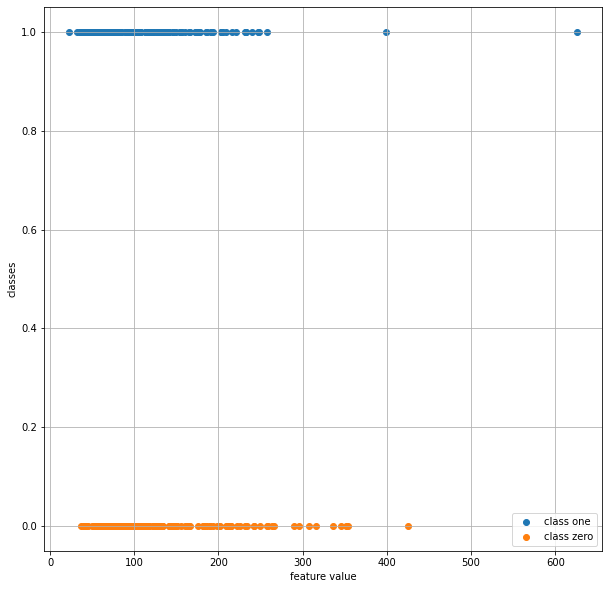

In [17]:
import matplotlib.pyplot as plt
numb_features = 32
Ind_features = np.zeros((numb_features,1), dtype=int)
Ind_features_time_domain = my_fisher(0, 770, Total_Features, int(numb_features/2))
Ind_features_freq_domain = my_fisher(770, 1498, Total_Features, int(numb_features/2))
Ind_features[0:int(numb_features/2)] = Ind_features_time_domain.reshape(int(numb_features/2),1)
Ind_features[int(numb_features/2):numb_features] = Ind_features_freq_domain.reshape(int(numb_features/2),1) + 770
# print(Ind_features.shape)

print('Time Domain features {} \n'.format(Ind_features_time_domain.transpose()))
print('Frequecncy Domain features {} \n'.format(Ind_features_freq_domain.transpose()+770))
print('Total features {} \n'.format(Ind_features.transpose()))

# print(my_fisher(0, 1246, Total_Features, 15))

x_train_NN = Total_Features[Ind_features[:,0],0:316].transpose()
x_test_NN = Total_Features[Ind_features[:,0],316:416].transpose()
y_train_NN = y_train.transpose()
# print(x_train_NN.shape, x_test_NN.shape, y_train_NN.shape)
# # a= 1246
j=0
k=0
classone = np.zeros((157,numb_features))
classzero = np.zeros((159,numb_features))
for i in range(316):
  if y_train_NN[i,0]==1:
    classone[j,:] = x_train_NN[i,:]
    j=j+1
  else:
    classzero[k,:] = x_train_NN[i,:]
    k=k+1
y_zero=np.zeros((159,1))
y_one=np.ones((157,1))
# print(classone[:,0].shape,y_one.shape)
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(classone[:,11],y_one)
ax.scatter(classzero[:,11],y_zero)
ax.grid(True)
ax.set_xlabel('feature value')
ax.set_ylabel('classes')
ax.legend(['class one','class zero']);

## K-Fold cross validation

In [18]:
from sklearn.model_selection import KFold, StratifiedKFold
from tensorflow.keras.layers import Input, Dense, Activation, Dropout, Softmax
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
def my_K_Fold_corss_validation(n_split, x_train_NN, y_train_NN, batch_number, epoch_numbers):
  acc_valid = np.zeros((1,n_split))
  j=0
  kfold = StratifiedKFold(n_splits=n_split, shuffle=True, random_state=0)
  for train, valid in kfold.split(x_train_NN, y_train_NN):
    scaler= StandardScaler()
    scaler.fit(x_train_NN[train])
    x_tr_norm = scaler.transform(x_train_NN[train])
    x_va_norm = scaler.transform(x_train_NN[valid])
    model = keras.Sequential([
                              Input(shape = (numb_features, )),
                              Dense(units = 128),
                              Activation(activation = 'relu'),
                              Dropout(0.05),
                              Dense(units = 256),
                              Activation(activation = 'relu'),
                              Dropout(0.1),
                              Dense(units = 128),
                              Activation(activation = 'relu'),
                              Dropout(0.1),
                              Dense(units = 1),
                              Activation(activation = tf.math.sigmoid),
                              ])

    model.compile(
        optimizer = keras.optimizers.SGD(learning_rate=0.0008),
        loss = keras.losses.BinaryCrossentropy(),
        metrics = ['accuracy']
    )

    er_stop = EarlyStopping(monitor='val_loss',patience=25,restore_best_weights=False)

    hist = model.fit(
        x_tr_norm,
        y_train_NN[train],
        batch_size = batch_number,
        epochs = epoch_numbers,
        validation_data = (x_va_norm, y_train_NN[valid]),
        callbacks = [er_stop],
        verbose=0
        )
    
    acc_valid[0,j] = model.evaluate(x_va_norm, y_train_NN[valid], verbose=0)[0]
    j=j+1
  return acc_valid

validation_accuracy = my_K_Fold_corss_validation(n_split=5, x_train_NN = x_train_NN, y_train_NN = y_train_NN, batch_number=128, epoch_numbers=2500)
print('validation_accuracy over  5 fold: {}. mean of validation_accuracy: {}'.format(validation_accuracy, validation_accuracy.mean()))

validation_accuracy over  5 fold: [[0.62322187 0.64569408 0.62607658 0.63780332 0.68082559]]. mean of validation_accuracy: 0.6427242875099182


### Train-validation split (one Fold)

In [19]:
from sklearn.model_selection import train_test_split

x_tr, x_va, y_tr, y_va = train_test_split(x_train_NN, y_train_NN, test_size=0.2, random_state=0)

## Preprocessing & Normalizing Data

In [20]:
from sklearn.preprocessing import StandardScaler

scaler= StandardScaler()
scaler.fit(x_tr)
x_tr_norm = scaler.transform(x_tr)
x_va_norm = scaler.transform(x_va)
x_te_norm = scaler.transform(x_test_NN)
print(x_tr_norm.shape, x_va_norm.shape, x_te_norm.shape)
# print(x_tr_norm[160:180,0:5])

(252, 32) (64, 32) (100, 32)


Text(0, 0.5, 'feature value')

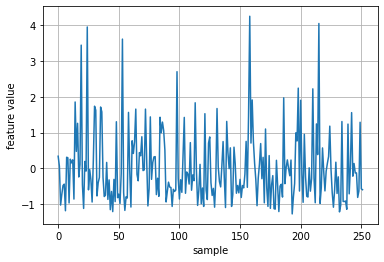

In [21]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot( x_tr_norm[:,14])
# ax.plot(epochs, hist.history['val_loss'])
ax.grid(True)
ax.set_xlabel('sample')
ax.set_ylabel('feature value')
# ax.legend(['Training','Validation']);

## MLP

### Setting up the layers


In [22]:
from tensorflow.keras.layers import Input, Dense, Activation, Dropout, Softmax

model = keras.Sequential([
                          Input(shape = (numb_features, )),
                          Dense(units = 128),
                          Activation(activation = 'relu'),
                          Dropout(0.05),
                          Dense(units = 256),
                          Activation(activation = 'relu'),
                          Dropout(0.1),
                          Dense(units = 128),
                          Activation(activation = 'relu'),
                          Dropout(0.1),
                          Dense(units = 1),
                          Activation(activation = tf.math.sigmoid),
                          ])
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 128)               4224      
                                                                 
 activation_20 (Activation)  (None, 128)               0         
                                                                 
 dropout_15 (Dropout)        (None, 128)               0         
                                                                 
 dense_21 (Dense)            (None, 256)               33024     
                                                                 
 activation_21 (Activation)  (None, 256)               0         
                                                                 
 dropout_16 (Dropout)        (None, 256)               0         
                                                                 
 dense_22 (Dense)            (None, 128)              

###Compiling the model
1. Optimizer
2. Loss function
3. Metrics


In [23]:
model.compile(
    optimizer = keras.optimizers.SGD(learning_rate=0.0008),
    loss = keras.losses.BinaryCrossentropy(),
    metrics = ['accuracy']
)

## Training the model
1. Train/Validation data
2. Batch size
3. Number of epochs
4. Callbacks

In [24]:
from tensorflow.keras.callbacks import EarlyStopping

er_stop = EarlyStopping(monitor='val_loss',patience=25,restore_best_weights=True)

hist = model.fit(
    x_tr_norm,
    y_tr,
    batch_size = 128,
    epochs = 2500,
    validation_data = (x_va_norm, y_va),
    callbacks = [er_stop],
    verbose=0
)
print(model.evaluate(x_va_norm, y_va, verbose=1))

2/2 [==============================] - 0s 10ms/step - loss: 0.6579 - accuracy: 0.6406
[0.6579054594039917, 0.640625]


## Loss and accuracy plots

<class 'keras.callbacks.History'>
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
<class 'list'>


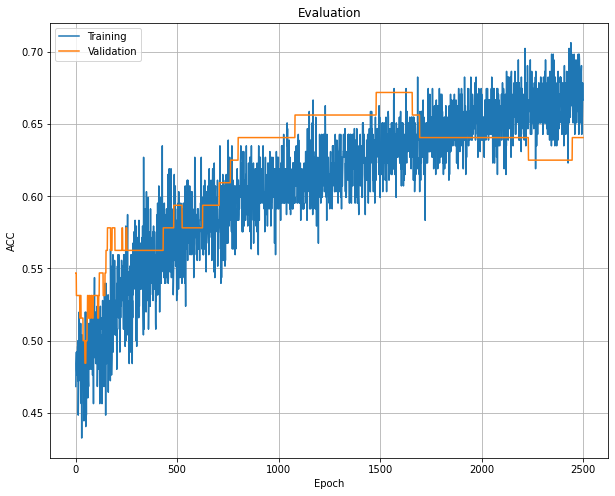

In [25]:
print(type(hist))
print (hist.history.keys())
print(type(hist.history['loss']))
n_epochs = len(hist.history['loss'])
epochs = np.arange(1,n_epochs+1)
fig, ax = plt.subplots(figsize=(10,8))
ax.plot(epochs, hist.history['accuracy'])
ax.plot(epochs, hist.history['val_accuracy'])
ax.grid(True)
ax.set_xlabel('Epoch')
ax.set_ylabel('ACC')
ax.set_title('Evaluation')
ax.legend(['Training','Validation']);

## Confusuin Matrix

(64, 1) (64, 1)


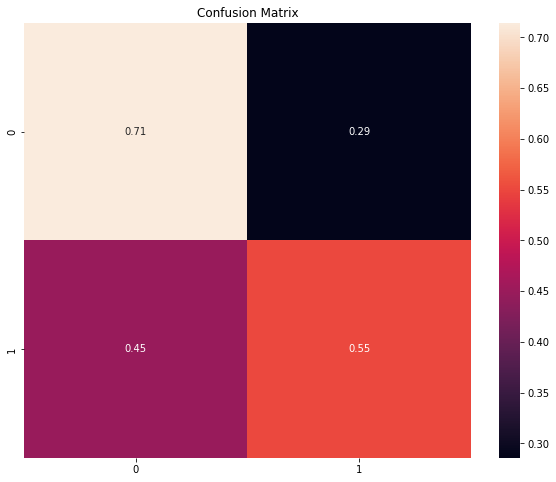

In [26]:
from seaborn import heatmap
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


y_pred = model.predict(x_va_norm)
print(y_pred.shape, y_va.shape)
for i in range(64):
  if(y_pred[i,0] > 0.5):
    y_pred[i,0] = 1
  else:
    y_pred[i,0] =0

cm = confusion_matrix(y_va, y_pred, normalize='true')

fig, ax = plt.subplots(figsize=(10,8))
ax.set_title("Confusion Matrix")
heatmap(cm,annot=True);
plt.show()

## ROC Curve plot

In [27]:
def plot_roc_curve(fpr,tpr): 
  plt.plot(fpr,tpr) 
  plt.axis([0,1,0,1]) 
  plt.xlabel('False Positive Rate') 
  plt.ylabel('True Positive Rate') 
  plt.show()    
  
# plot_roc_curve (fpr,tpr) 

## Creating Output Labels MLP

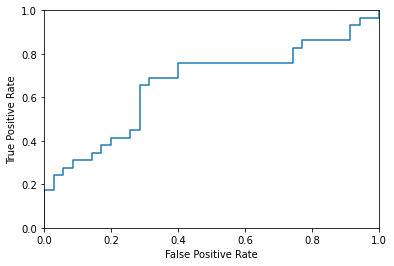

In [28]:
from sklearn.metrics import roc_curve
import scipy.io
y_va_predict = model.predict(x_va_norm)
y_te_predict = model.predict(x_te_norm)


fpr , tpr , thresholds = roc_curve ( y_va , y_va_predict)
best_distance = 1000
best_ind = 0
for i in range(len(fpr)):
  distance = (tpr[i] -1)**2 + fpr[i]**2
  if (best_distance > distance):
    best_distance = distance
    best_ind = i
plot_roc_curve (fpr,tpr)

threshold = thresholds[best_ind]

for i in range(100):
  if (y_te_predict[i, 0] > threshold):
    y_te_predict[i, 0] = 1
  else:
    y_te_predict[i, 0] =0
dic = {"y_labels": y_te_predict}
scipy.io.savemat('y_te_predict_MLP.mat', dic)

# RBF

## RBF impelementation

In [29]:
from keras.layers import Layer
from keras import backend as K

class RBFLayer(Layer):
    def __init__(self, units, gamma, **kwargs):
        super(RBFLayer, self).__init__(**kwargs)
        self.units = units
        self.gamma = K.cast_to_floatx(gamma)

    def build(self, input_shape):
#         print(input_shape)
#         print(self.units)
        self.mu = self.add_weight(name='mu',
                                  shape=(int(input_shape[1]), self.units),
                                  initializer='uniform',
                                  trainable=True)
        super(RBFLayer, self).build(input_shape)

    def call(self, inputs):
        diff = K.expand_dims(inputs) - self.mu
        l2 = K.sum(K.pow(diff, 2), axis=1)
        res = K.exp(-1 * self.gamma * l2)
        return res

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.units)

## RBF layers

In [30]:
from keras.layers import Dense, Flatten
from keras.models import Sequential
from keras.losses import binary_crossentropy

model = Sequential([Input(shape = (32, ))])
model.add(RBFLayer(512, 0.01))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss=binary_crossentropy, metrics = ['accuracy'])

In [31]:
from tensorflow.keras.callbacks import EarlyStopping

er_stop = EarlyStopping(monitor='val_loss',patience=25,restore_best_weights=True)

hist = model.fit(
    x_tr_norm,
    y_tr,
    batch_size = 128,
    epochs = 2500,
    validation_data = (x_va_norm, y_va),
    callbacks = [er_stop],
    verbose=0
)
print(model.evaluate(x_va_norm, y_va, verbose=0))

[0.6399961709976196, 0.609375]


## Creating Output Labels RBF

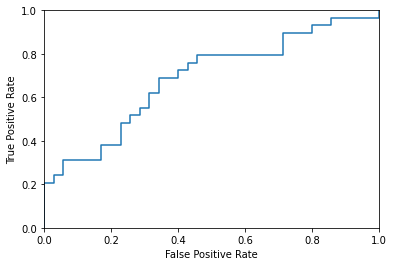

0.45718944


In [32]:
from sklearn.metrics import roc_curve
import scipy.io
y_va_predict = model.predict(x_va_norm)
y_te_predict = model.predict(x_te_norm)


fpr , tpr , thresholds = roc_curve ( y_va , y_va_predict)
best_distance = 1000
best_ind = 0
for i in range(len(fpr)):
  distance = (tpr[i] -1)**2 + fpr[i]**2
  if (best_distance > distance):
    best_distance = distance
    best_ind = i
plot_roc_curve (fpr,tpr)

threshold = thresholds[best_ind]
print(threshold)

for i in range(100):
  if (y_te_predict[i, 0] > threshold):
    y_te_predict[i, 0] = 1
  else:
    y_te_predict[i, 0] =0
dic = {"y_labels": y_te_predict}
scipy.io.savemat('y_te_predict_RBF.mat', dic)

## Genetic Algorithms

## Installing Library

In [33]:
# Docs: https://pyeasyga.readthedocs.io/en/latest/
!pip install pyeasyga

## Finding Best Features via Genetics

In [34]:
numb_features = 100
Ind_features = np.zeros((numb_features,1), dtype=int)
Ind_features_time_domain = my_fisher(0, 770, Total_Features, int(numb_features/2))
Ind_features_freq_domain = my_fisher(770, 1498, Total_Features, int(numb_features/2))
Ind_features[0:int(numb_features/2)] = Ind_features_time_domain.reshape(int(numb_features/2),1)
Ind_features[int(numb_features/2):numb_features] = Ind_features_freq_domain.reshape(int(numb_features/2),1) + 770
# print(Ind_features.shape)

print('Time Domain features {} \n'.format(Ind_features_time_domain.transpose()))
print('Frequecncy Domain features {} \n'.format(Ind_features_freq_domain.transpose()+770))
print('Total features {} \n'.format(Ind_features.transpose()))

# print(my_fisher(0, 1246, Total_Features, 15))

x_train_best_one_hundred = Total_Features[Ind_features[:,0],0:316]
x_test_best_one_hundred = Total_Features[Ind_features[:,0],316:416]

print(x_train_best_one_hundred.shape[1])


Time Domain features [[691 697  26 684 325 621 702  21 692  20 698 686 634 685 616 713 693 629
  615 352 351 622  14 513 678  13 694 631 607 679 726 358 350 512 609 719
  624 632 623 706 618 511 519 625 359 703 384 636  15 520]] 

Frequecncy Domain features [[ 891  898  915  957 1423  940  892  947  842  908  884 1332  782 1430
   810  922  775  873  866  859 1240  993 1081 1485  941 1039 1286 1333
   991  933 1099 1331  835 1178  789  899 1250 1436 1336 1171  953  824
  1492 1226  796  934 1169 1389 1080 1195]] 

Total features [[ 691  697   26  684  325  621  702   21  692   20  698  686  634  685
   616  713  693  629  615  352  351  622   14  513  678   13  694  631
   607  679  726  358  350  512  609  719  624  632  623  706  618  511
   519  625  359  703  384  636   15  520  891  898  915  957 1423  940
   892  947  842  908  884 1332  782 1430  810  922  775  873  866  859
  1240  993 1081 1485  941 1039 1286 1333  991  933 1099 1331  835 1178
   789  899 1250 1436 1336 1171  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide


In [35]:
# cost Function

def my_cost_function(X_Train, Y_Train):
  number_of_features = X_Train.shape[0]
  number_of_samples = X_Train.shape[1]
  Length_class_one= np.sum(y_train, axis=1)
  Class_one_features = np.zeros((number_of_features,int(Length_class_one)))
  Class_zero_features = np.zeros((number_of_features,number_of_samples-int(Length_class_one)))
  Fisher_score= np.zeros((number_of_features,1))
  j=0
  k=0
  for i in range(number_of_samples):
    if y_train[0,i]==1:
      Class_one_features[:,j]=X_Train[0:number_of_features,i]
      j+=1;
    else:
      Class_zero_features[:,k]=X_Train[0:number_of_features,i]
      k+=1;
  u_total = np.mean(X_Train[0:number_of_features, 0:number_of_samples], axis=1).reshape(number_of_features,1)
  u_class_one = np.mean(Class_one_features, axis=1).reshape(number_of_features,1)
  u_class_zero = np.mean(Class_zero_features, axis=1).reshape(number_of_features,1)
  S_one = np.zeros((number_of_features, number_of_features))
  S_zero = np.zeros((number_of_features, number_of_features))
  for i in range(int(Length_class_one)):
    S_one = S_one + np.matmul((Class_one_features[:, i].reshape(number_of_features,1) - u_class_one), (Class_one_features[:, i].reshape(number_of_features,1) - u_class_one).transpose())
  S_one = S_one / Length_class_one

  for i in range(int(number_of_samples-Length_class_one)):
    S_zero = S_zero + np.matmul((Class_zero_features[:, i].reshape(number_of_features,1) - u_class_zero), (Class_zero_features[:, i].reshape(number_of_features,1) - u_class_zero).transpose())
  S_zero = S_zero / (number_of_samples-Length_class_one)

  S_W = S_one + S_zero
  S_b = np.matmul( (u_class_one - u_total), (u_class_one - u_total).transpose() ) + np.matmul( (u_class_zero - u_total), (u_class_zero - u_total).transpose() )
  # print(S_W.shape, S_b.shape)
  J = np.trace(S_b)/np.trace(S_W)
  return J

# x_train = np.array([[1,2,3],[4,5,6],[7,8,9],[10,85,12],[13,14,15],[16,17,18]]).transpose()
# y_train = np.array([1,0,1,0,1,0]).reshape(1,6)
# print(x_train.shape, y_train.shape)
# J= my_cost_function(x_train,y_train)
# print(J)

In [36]:
import math
from pyeasyga import pyeasyga
import random
numb_features = 32
'''
GeneticAlgorithm:
        seed_data,
        population_size=50,
        generations=100,
        crossover_probability=0.8,
        mutation_probability=0.2,
        elitism=True,
        maximise_fitness=True
'''

def fitness(individual, data):
    x_train_best_thirty = np.zeros((numb_features,x_train_best_one_hundred.shape[1]))
    j=0
    for i in range(100):
      if individual[i] ==1:
        x_train_best_thirty[j,:] = x_train_best_one_hundred[i,:]
        j = j+1
    
    f= my_cost_function(x_train_best_thirty, y_train)
    return f

def crossover(parent_1, parent_2):
  child_1 = []
  child_2 = []
  Holder = []
  keeper = []
  keeper =[a + b for a, b in zip(parent_1, parent_2)]
  Holder = [element * 0.5 for element  in keeper]
  # Holder = (parent_1 + parent_2)/2
  toggle = False
  for i in range(len(parent_1)):
    if(Holder[i] == 0.5 and toggle ==False):
      child_1.append(math.floor(Holder[i]))
      child_2.append(math.ceil(Holder[i]))
      toggle = not toggle

    elif(Holder[i] == 0.5 and toggle ==True):
      child_1.append(math.ceil(Holder[i]))
      child_2.append(math.floor(Holder[i]))
      toggle = not toggle

    else:
      child_1.append(Holder[i])
      child_2.append(Holder[i])
  
  return child_1,child_2

def mutate(individual):
    """Reverse two bits of a two random indexes in an individual."""
    mutate_index1 = random.randrange(len(individual))
    dummy1 = individual[mutate_index1]
    mutate_index2 = random.randrange(len(individual))
    dummy2 = individual[mutate_index2]
    while(dummy1 == dummy2):
      mutate_index2 = random.randrange(len(individual))
      dummy2 = individual[mutate_index2] 
    individual[mutate_index1] = (0, 1)[individual[mutate_index1] == 0]
    individual[mutate_index2] = (0, 1)[individual[mutate_index2] == 0]

def my_create_individual(seed_data):
    """Create a candidate solution representation.

    e.g. for a bit array representation:

    >>> return [random.randint(0, 1) for _ in range(len(data))]

    :param seed_data: input data to the Genetic Algorithm
    :type seed_data: list of objects
    :returns: candidate solution representation as a list

    """
    lst = [0] * len(seed_data)
    Ind = random.sample(range(0, len(seed_data)), numb_features)
    for i in range(numb_features):
      lst[Ind[i]] = 1

    return lst

data = [0]*100
ga = pyeasyga.GeneticAlgorithm(data)
ga.population_size = 128
ga.generations = 512
ga.fitness_function = fitness
ga.crossover_function = crossover
ga.mutate_function  = mutate
ga.create_individual = my_create_individual 

ga.run()
# type(ga.best_individual)
print(f'Best individual: {ga.best_individual()}')

Best individual: (0.029394766743790806, [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1, 0.0, 0.0, 0.0, 0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0])


In [37]:
Best_ind_thrity_features = np.zeros((100,1))
x_train_best = np.zeros((numb_features,316))
x_test_best = np.zeros((numb_features,100))
Best_ind_thrity_features = ((np.asarray(ga.best_individual()[1], dtype=int)).reshape(100,1))
j = 0
for i in range(100):
  if (Best_ind_thrity_features[i] == 1):
    x_train_best[j, :] = x_train_best_one_hundred[i, :]
    x_test_best[j, :] = x_test_best_one_hundred[i, :]
    j = j+1

## Again Traing NN and evaluating via K-Fold Cross Validation

In [38]:
from sklearn.model_selection import KFold, StratifiedKFold
from tensorflow.keras.layers import Input, Dense, Activation, Dropout, Softmax
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
def my_K_Fold_corss_validation(n_split, x_train_NN, y_train_NN, batch_number, epoch_numbers):
  acc_valid = np.zeros((1,n_split))
  j=0
  kfold = StratifiedKFold(n_splits=n_split, shuffle=True, random_state=0)
  for train, valid in kfold.split(x_train_NN, y_train_NN):
    scaler= StandardScaler()
    scaler.fit(x_train_NN[train])
    x_tr_norm = scaler.transform(x_train_NN[train])
    x_va_norm = scaler.transform(x_train_NN[valid])
    model = keras.Sequential([
                              Input(shape = (numb_features, )),
                              Dense(units = 128),
                              Activation(activation = 'relu'),
                              Dropout(0.05),
                              Dense(units = 256),
                              Activation(activation = 'relu'),
                              Dropout(0.1),
                              Dense(units = 128),
                              Activation(activation = 'relu'),
                              Dropout(0.1),
                              Dense(units = 1),
                              Activation(activation = tf.math.sigmoid),
                              ])

    model.compile(
        optimizer = keras.optimizers.SGD(learning_rate=0.0008),
        loss = keras.losses.BinaryCrossentropy(),
        metrics = ['accuracy']
    )

    er_stop = EarlyStopping(monitor='val_loss',patience=25,restore_best_weights=False)

    hist = model.fit(
        x_tr_norm,
        y_train_NN[train],
        batch_size = batch_number,
        epochs = epoch_numbers,
        validation_data = (x_va_norm, y_train_NN[valid]),
        callbacks = [er_stop],
        verbose=0
        )
    
    acc_valid[0,j] = model.evaluate(x_va_norm, y_train_NN[valid], verbose=0)[0]
    j=j+1
  return acc_valid

validation_accuracy = my_K_Fold_corss_validation(n_split=5, x_train_NN = x_train_best.transpose(), y_train_NN = y_train_NN, batch_number=128, epoch_numbers=2500)
print(validation_accuracy, validation_accuracy.mean())

[[0.6335938  0.60901302 0.61875772 0.63318247 0.69530183]] 0.6379697680473327


## Again Training via One Fold for creating output labels

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_45 (Dense)            (None, 128)               4224      
                                                                 
 activation_44 (Activation)  (None, 128)               0         
                                                                 
 dropout_33 (Dropout)        (None, 128)               0         
                                                                 
 dense_46 (Dense)            (None, 256)               33024     
                                                                 
 activation_45 (Activation)  (None, 256)               0         
                                                                 
 dropout_34 (Dropout)        (None, 256)               0         
                                                                 
 dense_47 (Dense)            (None, 128)             

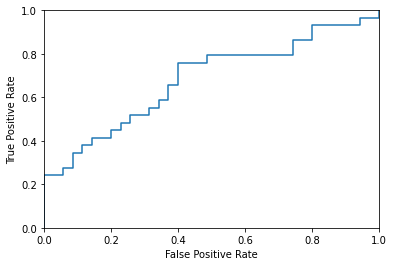

In [43]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve
import scipy.io
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input, Dense, Activation, Dropout, Softmax

x_tr, x_va, y_tr, y_va = train_test_split(x_train_best.transpose(), y_train_NN, test_size=0.2, random_state=0)
# print(x_test_best.shape)
scaler= StandardScaler()
scaler.fit(x_tr)
x_tr_norm = scaler.transform(x_tr)
x_va_norm = scaler.transform(x_va)
x_te_norm = scaler.transform(x_test_best.transpose())
# print(x_tr_norm.shape, x_va_norm.shape, x_te_norm.shape)
# # print(x_tr_norm[160:180,0:5])



model = keras.Sequential([
                          Input(shape = (numb_features, )),
                          Dense(units = 128),
                          Activation(activation = 'relu'),
                          Dropout(0.05),
                          Dense(units = 256),
                          Activation(activation = 'relu'),
                          Dropout(0.1),
                          Dense(units = 128),
                          Activation(activation = 'relu'),
                          Dropout(0.1),
                          Dense(units = 1),
                          Activation(activation = tf.math.sigmoid),
                          ])
model.summary()

model.compile(
    optimizer = keras.optimizers.SGD(learning_rate=0.0008),
    loss = keras.losses.BinaryCrossentropy(),
    metrics = ['accuracy']
)


er_stop = EarlyStopping(monitor='val_loss',patience=25,restore_best_weights=True)

hist = model.fit(
    x_tr_norm,
    y_tr,
    batch_size = 128,
    epochs = 2500,
    validation_data = (x_va_norm, y_va),
    callbacks = [er_stop],
    verbose=0
)
print(model.evaluate(x_va_norm, y_va, verbose=1))


y_va_predict = model.predict(x_va_norm)
y_te_predict = model.predict(x_te_norm)


fpr , tpr , thresholds = roc_curve ( y_va , y_va_predict)
best_distance = 1000
best_ind = 0
for i in range(len(fpr)):
  distance = (tpr[i] -1)**2 + fpr[i]**2
  if (best_distance > distance):
    best_distance = distance
    best_ind = i
plot_roc_curve (fpr,tpr)

threshold = thresholds[best_ind]

for i in range(100):
  if (y_te_predict[i, 0] > threshold):
    y_te_predict[i, 0] = 1
  else:
    y_te_predict[i, 0] =0
dic = {"y_labels": y_te_predict}
scipy.io.savemat('y_te_predict_MLP_Genetics.mat', dic)

## Again Training RBF for Creating output labels

[0.6415730714797974, 0.625]


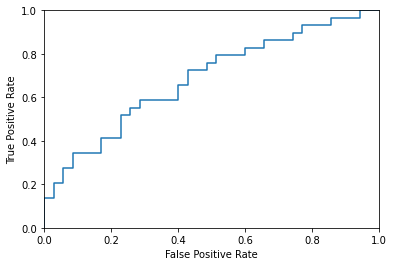

0.4419487


In [45]:
from keras.layers import Dense, Flatten
from keras.models import Sequential
from keras.losses import binary_crossentropy
from tensorflow.keras.callbacks import EarlyStopping

model = Sequential([Input(shape = (32, ))])
model.add(RBFLayer(512, 0.01))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss=binary_crossentropy, metrics = ['accuracy'])



er_stop = EarlyStopping(monitor='val_loss',patience=25,restore_best_weights=True)

hist = model.fit(
    x_tr_norm,
    y_tr,
    batch_size = 128,
    epochs = 2500,
    validation_data = (x_va_norm, y_va),
    callbacks = [er_stop],
    verbose=0
)
print(model.evaluate(x_va_norm, y_va, verbose=0))


from sklearn.metrics import roc_curve
import scipy.io
y_va_predict = model.predict(x_va_norm)
y_te_predict = model.predict(x_te_norm)


fpr , tpr , thresholds = roc_curve ( y_va , y_va_predict)
best_distance = 1000
best_ind = 0
for i in range(len(fpr)):
  distance = (tpr[i] -1)**2 + fpr[i]**2
  if (best_distance > distance):
    best_distance = distance
    best_ind = i
plot_roc_curve (fpr,tpr)

threshold = thresholds[best_ind]
print(threshold)

for i in range(100):
  if (y_te_predict[i, 0] > threshold):
    y_te_predict[i, 0] = 1
  else:
    y_te_predict[i, 0] =0
dic = {"y_labels": y_te_predict}
scipy.io.savemat('y_te_predict_RBF_Genetics.mat', dic)